# Linear Regression
#### A linear regression model to predict house price

**Data and libraries import:**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('data/house-prices.csv')
X = df[['SqFt', 'Bedrooms', 'Bathrooms', 'Offers', 'Brick', 'Neighborhood']]  
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

_____________________
_____________________
### Preprocessing Data
showing Data's Info and Missed value count:

In [2]:
# Check for missing values
print("Missing values per column:\n", X_train.isna().sum())
# Display data info
print("\nData info:\n")
print(X_train.info())
# Display summary statistics
print("\nSummary statistics:\n")
print(X_train.describe())

Missing values per column:
 SqFt            2
Bedrooms        3
Bathrooms       1
Offers          2
Brick           0
Neighborhood    0
dtype: int64

Data info:

<class 'pandas.core.frame.DataFrame'>
Index: 115 entries, 4 to 102
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SqFt          113 non-null    float64
 1   Bedrooms      112 non-null    float64
 2   Bathrooms     114 non-null    float64
 3   Offers        113 non-null    float64
 4   Brick         115 non-null    object 
 5   Neighborhood  115 non-null    object 
dtypes: float64(4), object(2)
memory usage: 6.3+ KB
None

Summary statistics:

              SqFt    Bedrooms   Bathrooms      Offers
count   113.000000  112.000000  114.000000  113.000000
mean   2008.761062    3.026786    2.464912    2.592920
std     214.247574    0.728565    0.518333    1.090848
min    1450.000000    2.000000    2.000000    1.000000
25%    1890.000000    3.000000    2.00000

_____________________
#### Recovery Missed Values:
Replacing numerical missed values with *mean* and categorical missed values with *mode*

In [3]:
# Fill missing numerical values with the mean
numerical_cols = ['SqFt', 'Bedrooms', 'Bathrooms', 'Offers']
for col in numerical_cols:
    X_train[col].fillna(X_train[col].mean(), inplace=True)
    X_test[col].fillna(X_train[col].mean(), inplace=True)  # Use train mean for test set

# Fill missing categorical values with the mode
categorical_cols = ['Brick', 'Neighborhood']
for col in categorical_cols:
    X_train[col].fillna(X_train[col].mode()[0], inplace=True)
    X_test[col].fillna(X_train[col].mode()[0], inplace=True)  # Use train mode for test set
    
print("Missing values per column after recovery:\n", X_train.isna().sum())
print(X_train.describe())

Missing values per column after recovery:
 SqFt            0
Bedrooms        0
Bathrooms       0
Offers          0
Brick           0
Neighborhood    0
dtype: int64
              SqFt    Bedrooms   Bathrooms      Offers
count   115.000000  115.000000  115.000000  115.000000
mean   2008.761062    3.026786    2.464912    2.592920
std     212.359893    0.718915    0.516055    1.081237
min    1450.000000    2.000000    2.000000    1.000000
25%    1895.000000    3.000000    2.000000    2.000000
50%    2000.000000    3.000000    2.000000    3.000000
75%    2145.000000    3.026786    3.000000    3.000000
max    2590.000000    5.000000    4.000000    6.000000


___________________
#### Removing Outliers:
removing outliers of numercial columns using IQR method. this method wouldn't be applied to *Bedroom* column because most of data are outlier.(due to distribution of this feature it should not include in training model)

In [4]:
n = X_train.shape[0]
# Detect outliers in X_train using the IQR method
for col in numerical_cols:
    if col == 'Bedrooms':
        continue
    Q1 = X_train[col].quantile(0.25)  # First quartile
    Q3 = X_train[col].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Inter-quartile range

    # Define outlier limits
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    X_train = X_train[(X_train[col] >= lower_bound) & (X_train[col] <= upper_bound)]
    y_train = y_train.loc[X_train.index]  # Keep labels aligned
    

# Display number of removed outliers
print(f"Original train size: {n}")
print(f"Train size after outlier removal: {X_train.shape[0]}")
print(f"Number of outliers removed: {n - X_train.shape[0]}")
print(f"Test size remains unchanged: {X_test.shape[0]}")
print(X_train.describe())

Original train size: 115
Train size after outlier removal: 108
Number of outliers removed: 7
Test size remains unchanged: 13
              SqFt    Bedrooms   Bathrooms      Offers
count   108.000000  108.000000  108.000000  108.000000
mean   1999.699279    3.019263    2.458008    2.483202
std     196.360429    0.723194    0.516646    0.949603
min    1520.000000    2.000000    2.000000    1.000000
25%    1887.500000    3.000000    2.000000    2.000000
50%    2000.000000    3.000000    2.000000    3.000000
75%    2132.500000    3.026786    3.000000    3.000000
max    2440.000000    5.000000    4.000000    4.000000


_____________________
#### Encode Categorical Data
encode *Brick* column using Label Encoding because it has binary values and encode *Neighborhood* column using One-Hot Encoding.

In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}  # Store LabelEncoders

# Label Encoding for Binary Categorical Data (Yes/No)
binary_cols = ['Brick']  # Binary categorical columns
for col in binary_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])  # Fit & transform train data
    X_test[col] = le.transform(X_test[col])  # Transform test data using same encoder
    label_encoders[col] = le  # Store encoder for future use

# One-Hot Encoding for Nominal Categorical Data (Neighborhood)
X_train = pd.get_dummies(X_train, columns=['Neighborhood'])
X_test = pd.get_dummies(X_test, columns=['Neighborhood'])

# Ensure test set has the same columns as train set
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0  # Add missing columns with default value 0

# Reorder columns to match train set
X_test = X_test[X_train.columns]

# Display final dataset info
print(f"Final train size: {X_train.shape[0]}")
print(f"Final test size: {X_test.shape[0]}")
print(X_train.head())  # Preview encoded data


Final train size: 108
Final test size: 13
       SqFt  Bedrooms  Bathrooms  Offers  Brick  Neighborhood_East  \
4    2130.0       3.0        3.0     3.0      0               True   
96   2440.0       3.0        3.0     3.0      0               True   
113  2000.0       3.0        2.0     3.0      1              False   
36   1880.0       2.0        2.0     2.0      0              False   
80   2190.0       3.0        3.0     4.0      1               True   

     Neighborhood_North  Neighborhood_West  
4                 False              False  
96                False              False  
113                True              False  
36                 True              False  
80                False              False  


______________________________________________
#### Data Analysis & Charts

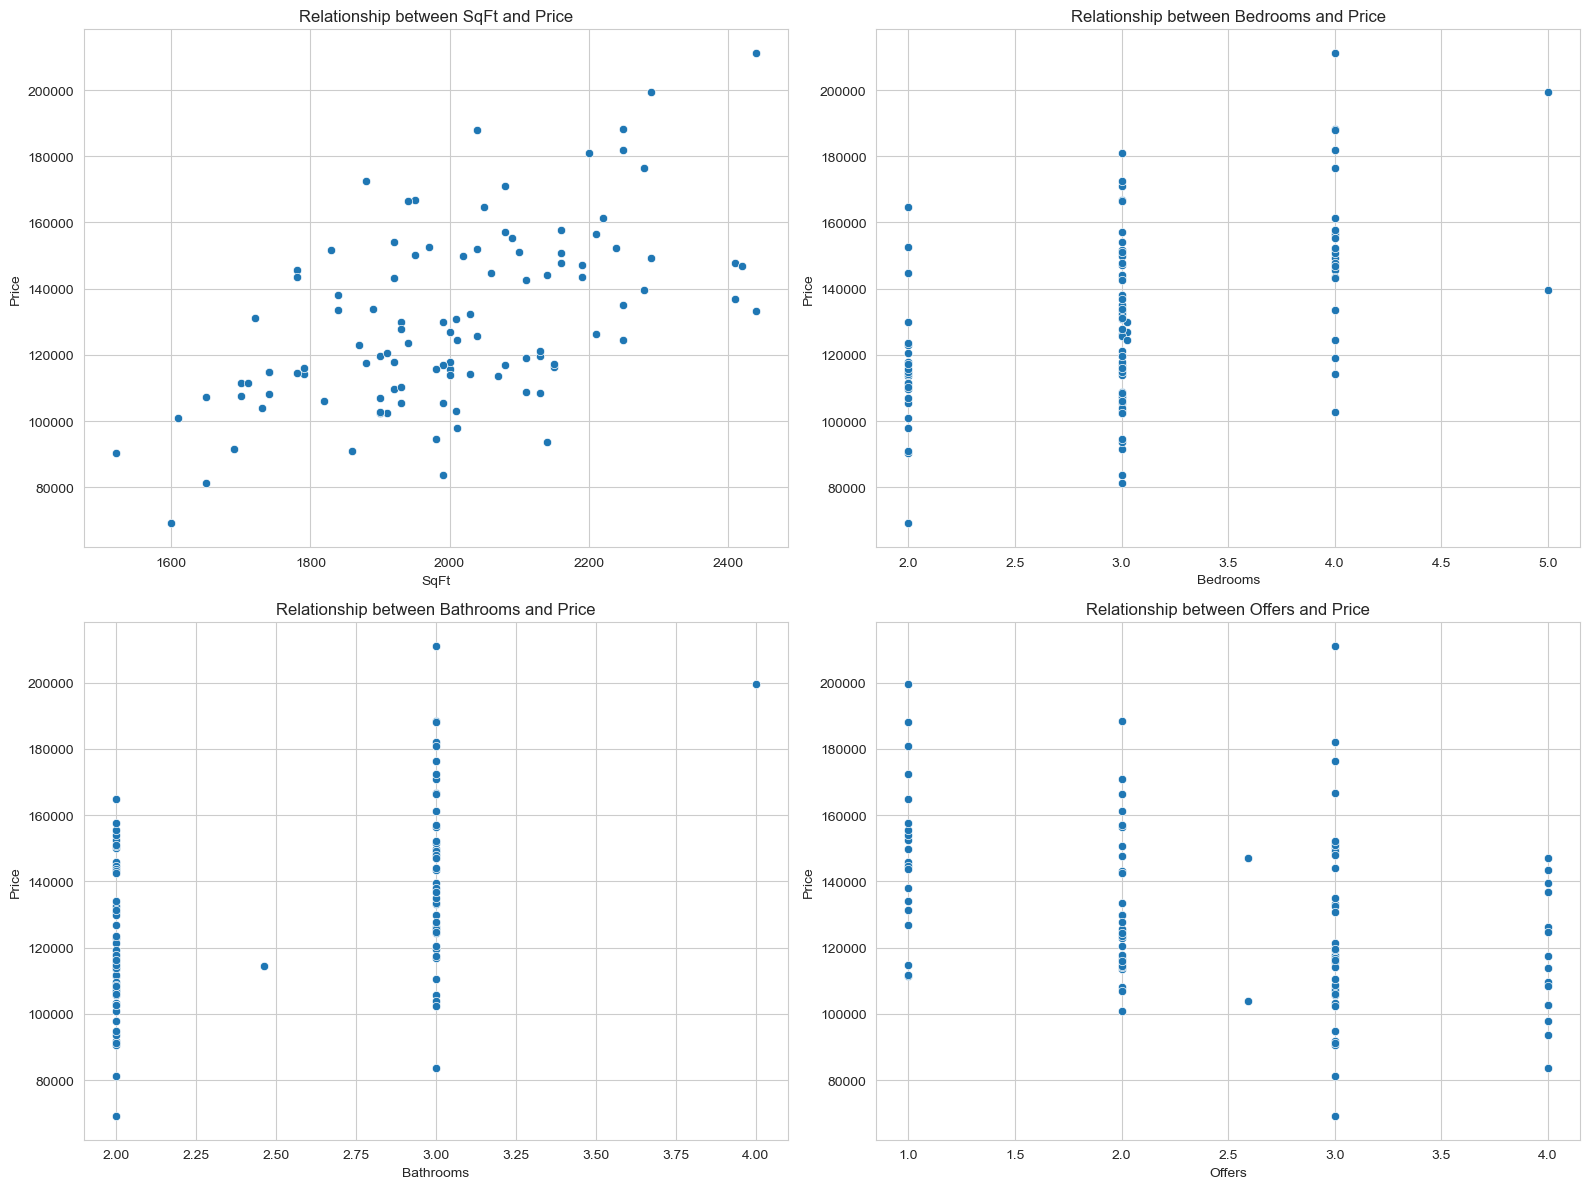

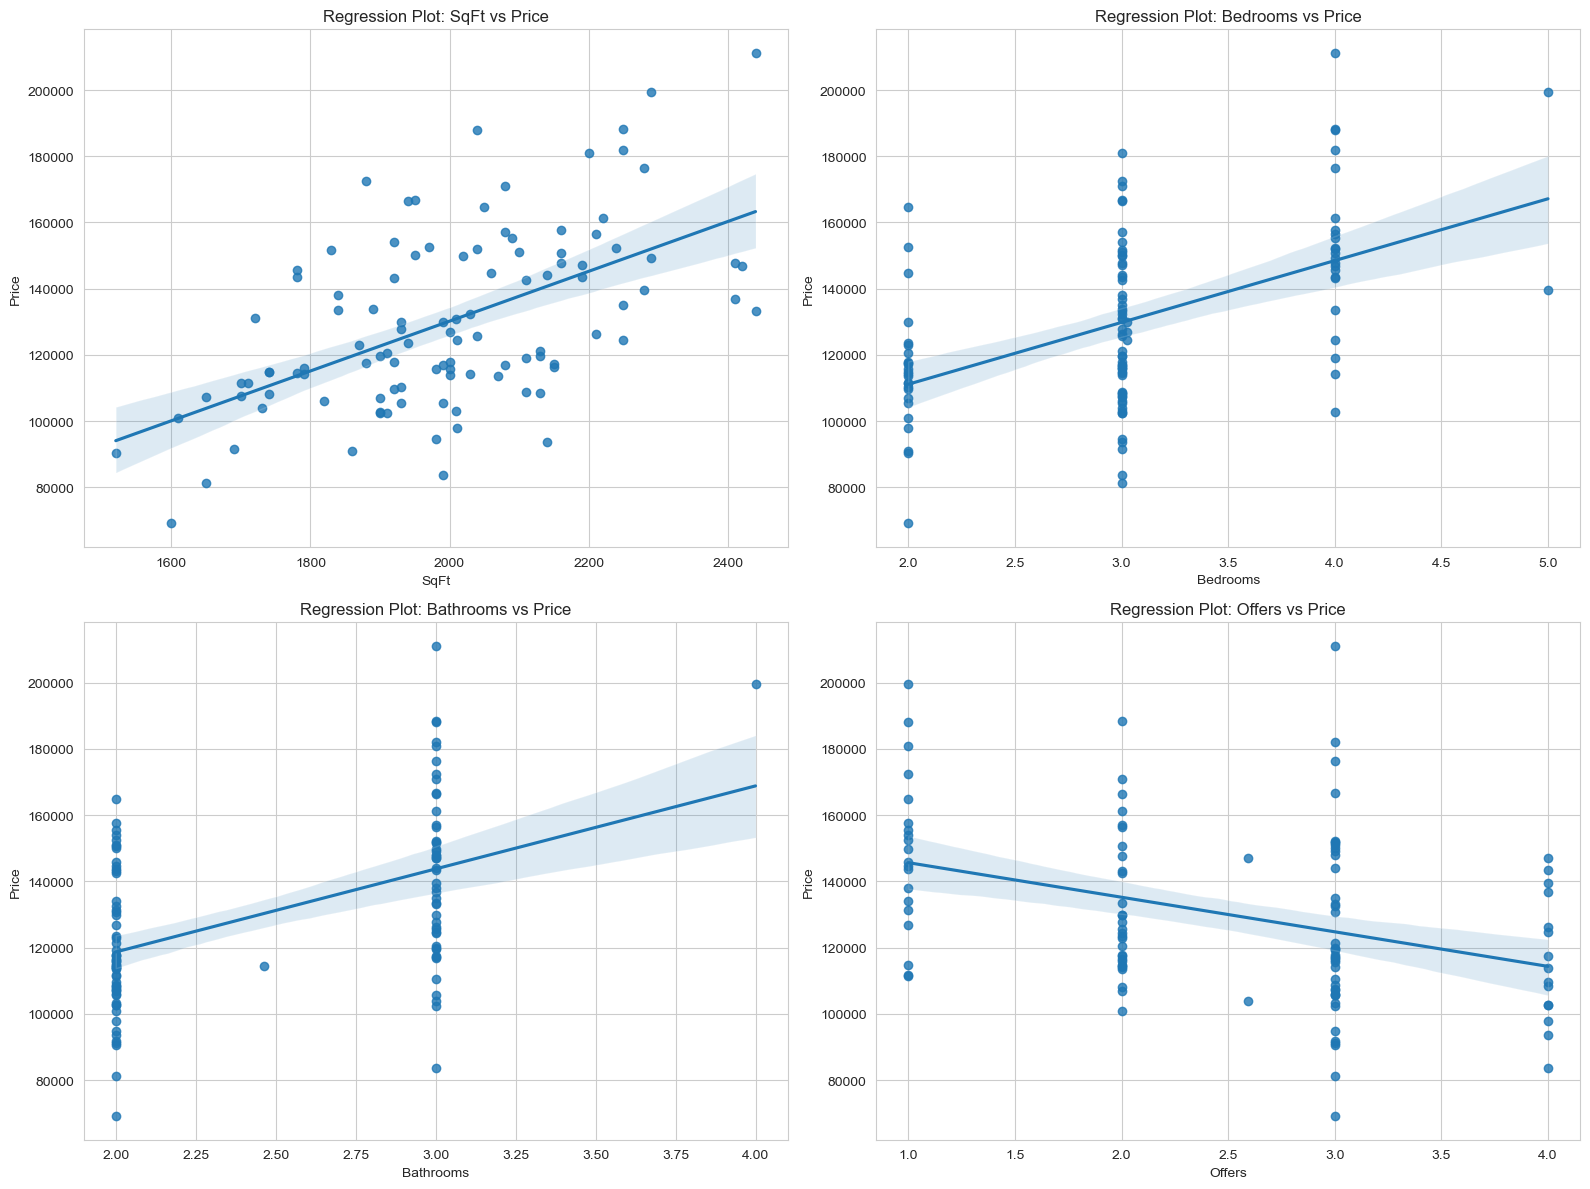

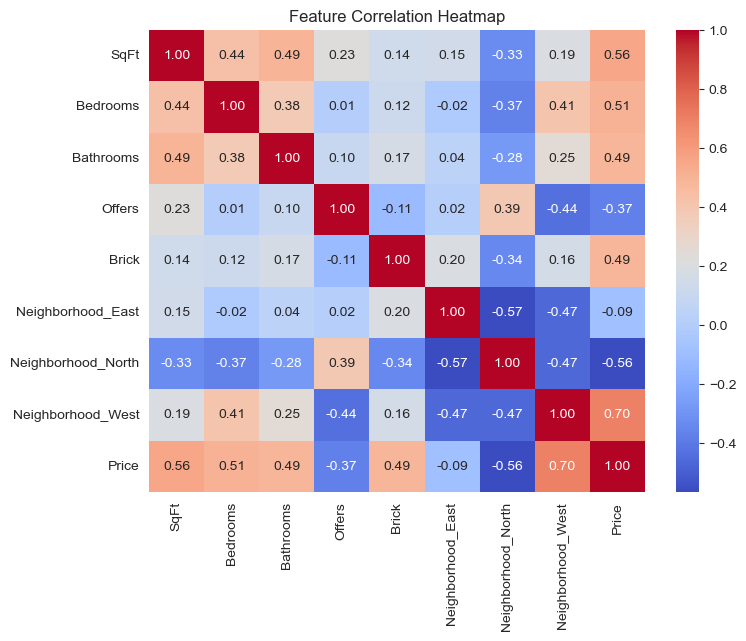

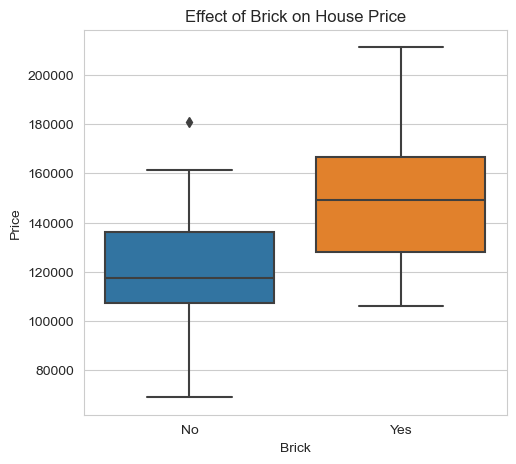

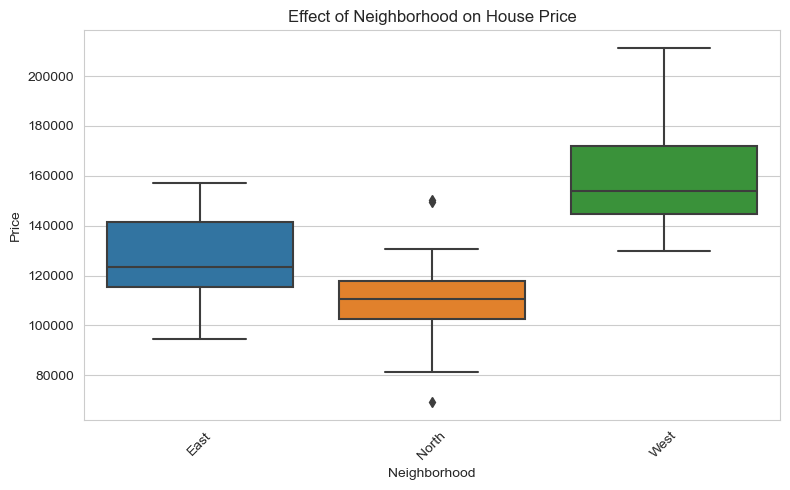

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine into a single DataFrame for visualization
df_visual = X_train.copy()
df_visual['Price'] = y_train  # Use y_train, not y

# Set Seaborn style
sns.set_style("whitegrid")

# Scatter Plots for Numerical Features
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i+1)
    sns.scatterplot(x=df_visual[col], y=df_visual['Price'])
    plt.title(f'Relationship between {col} and Price')

plt.tight_layout()
plt.show()

# Regression Plots for Numerical Features
plt.figure(figsize=(16, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i+1)
    sns.regplot(x=df_visual[col], y=df_visual['Price'])
    plt.title(f'Regression Plot: {col} vs Price')

plt.tight_layout()
plt.show()

# Heatmap for Feature Correlation
plt.figure(figsize=(8, 6))
sns.heatmap(df_visual.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Boxplots for Categorical Features
plt.figure(figsize=(12, 5))

# Brick vs Price (Binary Categorical)
plt.subplot(1, 2, 1)
sns.boxplot(x=df_visual['Brick'], y=df_visual['Price'])
plt.xticks([0, 1], ['No', 'Yes'])  # Convert 0/1 back to labels
plt.title("Effect of Brick on House Price")

# Neighborhood vs Price (One-Hot Encoded)
# plt.subplot(1, 2, 2)
# sns.boxplot(data=df_visual, y='Price')
# plt.title("Effect of Neighborhood on House Price")
# plt.xticks([])  # Remove x-axis labels since Neighborhood is one-hot encoded

# Convert one-hot encoded neighborhoods back into a single categorical column
df_visual['Neighborhood'] = df_visual[['Neighborhood_West', 'Neighborhood_North', 'Neighborhood_East']].idxmax(axis=1)
df_visual['Neighborhood'] = df_visual['Neighborhood'].str.replace('Neighborhood_', '')  # Clean column names

plt.figure(figsize=(8, 5))
sns.boxplot(x=df_visual['Neighborhood'], y=df_visual['Price'])
plt.title("Effect of Neighborhood on House Price")
plt.xticks(rotation=45)
# plt.show()


plt.tight_layout()
plt.show()


________________
#### Normalize Data
normalizing numerical data using Min-Max Scaler

In [7]:
from sklearn.preprocessing import MinMaxScaler
# Normalize features using Min-Max Scaling
scaler = MinMaxScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])  # Use transform, not fit_transform
print("Normalized X_train:\n", X_train[:20])


Normalized X_train:
          SqFt  Bedrooms  Bathrooms    Offers  Brick  Neighborhood_East  \
4    0.663043  0.333333        0.5  0.666667      0               True   
96   1.000000  0.333333        0.5  0.666667      0               True   
113  0.521739  0.333333        0.0  0.666667      1              False   
36   0.391304  0.000000        0.0  0.333333      0              False   
80   0.728261  0.333333        0.5  1.000000      1               True   
125  0.597826  0.000000        0.0  0.333333      0              False   
84   0.000000  0.000000        0.0  0.666667      0              False   
18   0.195652  0.000000        0.0  0.000000      1               True   
10   0.554348  0.333333        0.0  0.666667      1               True   
118  0.467391  0.333333        0.0  0.666667      1              False   
11   0.380435  0.000000        0.0  0.333333      1               True   
45   0.531262  0.333333        0.0  0.666667      0               True   
70   0.467391  0.

_______________________
_______________________
### Train Model
training model using gradient descent

Epoch 0: RMSE Loss = 132836.6645
Epoch 100: RMSE Loss = 18753.7405
Epoch 200: RMSE Loss = 15586.0958
Epoch 300: RMSE Loss = 14097.4410
Epoch 400: RMSE Loss = 13201.8796
Epoch 500: RMSE Loss = 12571.5401
Epoch 600: RMSE Loss = 12094.0674
Epoch 700: RMSE Loss = 11721.6439
Epoch 800: RMSE Loss = 11427.6264
Epoch 900: RMSE Loss = 11194.0029
Epoch 1000: RMSE Loss = 11007.4212
Epoch 1100: RMSE Loss = 10857.6447
Epoch 1200: RMSE Loss = 10736.7463
Epoch 1300: RMSE Loss = 10638.5741
Epoch 1400: RMSE Loss = 10558.3525
Epoch 1500: RMSE Loss = 10492.3721
Epoch 1600: RMSE Loss = 10437.7478
Epoch 1700: RMSE Loss = 10392.2302
Epoch 1800: RMSE Loss = 10354.0599
Epoch 1900: RMSE Loss = 10321.8549
Epoch 2000: RMSE Loss = 10294.5244
Epoch 2100: RMSE Loss = 10271.2029
Epoch 2200: RMSE Loss = 10251.1997
Epoch 2300: RMSE Loss = 10233.9602
Epoch 2400: RMSE Loss = 10219.0363
Epoch 2500: RMSE Loss = 10206.0637
Epoch 2600: RMSE Loss = 10194.7441
Epoch 2700: RMSE Loss = 10184.8323
Epoch 2800: RMSE Loss = 10176.1

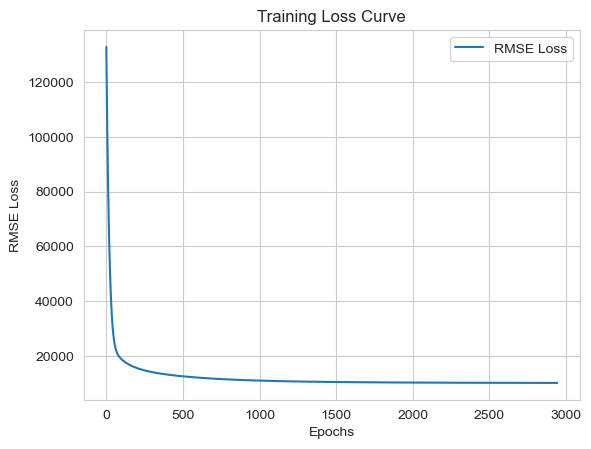

Test Loss (RMSE): 9584.2705


In [8]:
import numpy as np
import matplotlib.pyplot as plt

class LinearRegressionScratch:
    def __init__(self, learning_rate=0.01, epochs=1000, tolerance=1e-6, patience=10):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.tolerance = tolerance  # Threshold for small RMSE change
        self.patience = patience  # Number of consecutive small changes before stopping
        self.W = None  # Weights
        self.b = 0  # Bias
        self.loss_history = []  # Store RMSE loss over epochs

    def compute_rmse(self, y_true, y_pred):
        """Compute Root Mean Squared Error (RMSE)"""
        mse = np.mean((y_pred - y_true) ** 2)
        return np.sqrt(mse)

    def fit(self, X_train, y_train):
        """Train the model using Gradient Descent with Convergence Counter"""
        m, n = X_train.shape  # m = samples, n = features
        self.W = np.zeros(n)  # Initialize weights to zero
        self.b = 0  # Initialize bias

        no_change_count = 0  # Count epochs with small RMSE change

        for epoch in range(self.epochs):
            # Compute predictions
            y_pred = np.dot(X_train, self.W) + self.b
            
            # Compute RMSE loss
            loss = self.compute_rmse(y_train, y_pred)
            self.loss_history.append(loss)

            # Count consecutive small changes
            if epoch > 0 and abs(self.loss_history[-2] - loss) < self.tolerance:
                no_change_count += 1
            else:
                no_change_count = 0  # Reset counter if change is significant

            # Stop if we reach 10 consecutive small changes
            if no_change_count >= self.patience:
                print(f"Early stopping at epoch {epoch}, RMSE: {loss:.4f}")
                break

            # Compute gradients
            dW = (2/m) * np.dot(X_train.T, (y_pred - y_train))  # Gradient for weights
            db = (2/m) * np.sum(y_pred - y_train)  # Gradient for bias

            # Update parameters
            self.W -= self.learning_rate * dW
            self.b -= self.learning_rate * db

            # Print loss every 100 epochs
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: RMSE Loss = {loss:.4f}")

    def predict(self, X_test):
        """Make predictions"""
        return np.dot(X_test, self.W) + self.b

    def plot_loss(self):
        """Plot RMSE loss over epochs"""
        plt.plot(range(len(self.loss_history)), self.loss_history, label="RMSE Loss")
        plt.xlabel("Epochs")
        plt.ylabel("RMSE Loss")
        plt.title("Training Loss Curve")
        plt.legend()
        plt.show()

# Ensure all data is numeric
X_train = X_train.astype(float)
X_test = X_test.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Train the model
model = LinearRegressionScratch(learning_rate=0.01, epochs=10000, tolerance=0.07, patience=20)
model.fit(X_train, y_train)

# Plot RMSE loss curve
model.plot_loss()

# Test the model
y_test_pred = model.predict(X_test)

# Compute RMSE on test set
test_rmse = model.compute_rmse(y_test, y_test_pred)
print(f"Test Loss (RMSE): {test_rmse:.4f}")
